### Model9 settings:

We drop 'half-true' datas and combine classes to 2 classes.

Then we have full preproccesing on data.

Then we tokenized and used Word2Vec on data.

Stacking is by binary prediction of models.

Embedding dim is 150


In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt 
from sklearn.metrics import precision_recall_fscore_support
import Scripts.Data_Read_Prepare as Data_Prepare
import Scripts.Fake_News_Detection_SVM as SVM_classifier
import Scripts.Fake_News_Detection_PA as PA_classifier
import Scripts.Fake_News_Detection_XGBoost as XGBoost_classifier
import Scripts.Fake_News_Detection_LSTM as LSTM_classifier
import Scripts.Fake_News_Detection_BiLSTM as BiLSTM_classifier
import Scripts.Fake_News_Detection_Stacked_MLP as MLP_classifier

Loading data from datasets

In [2]:
data_train, data_valid, data_test = Data_Prepare.read_data()
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
data_train = Data_Prepare.combine_classes_drop_half_true(data_train)
data_valid = Data_Prepare.combine_classes_drop_half_true(data_valid)
data_test = Data_Prepare.combine_classes_drop_half_true(data_test)
data_train.head(3)

,label,sentence
0,0,abortion dwayne-bohac State representative a m...
1,1,foreign-policy barack-obama President Denver H...
2,0,health-care blog-posting nan a news release He...


Preproccesing

In [4]:
data_train, data_valid, data_test = Data_Prepare.do_preprocessing(data_train, data_valid, data_test)

data_preprocessing done!


In [5]:
data_train['label'].value_counts(normalize='true')

0    0.552301
1    0.447699
Name: label, dtype: float64

In [5]:
# Combine the training and validation datasets for training
data_set_all = pd.concat([data_train, data_valid, data_test])
data_train_valid = pd.concat([data_train, data_valid])

X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

In [7]:
# plot_data_length(data_set_all)

Vectorizing

In [6]:
embedding_matrix,X_train_t_v, y_train_t_v, X_test_t_v, y_test_t_v, vocab_size = Data_Prepare.tokenize_vectorize(data_set_all,
                                                                                                                data_train_valid,
                                                                                                                data_test,
                                                                                                                MAX_SEQUENCE_LENGTH=300
                                                                                                                ,EMBEDDING_DIM=150)

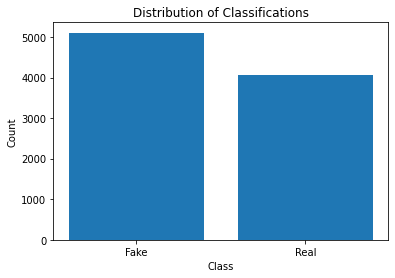

In [27]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_train_valid)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## 1- SVM

In [12]:
svm_predictions, svm_train_valid_predictions =SVM_classifier.train_svm(X_train_t_v, y_train_valid, X_test_t_v)

Execution time of SVM: 18.51 seconds


SVM - accuracy: 0.48902195608782434
SVM - Precision: 0.43737574552683894
SVM - Recall: 0.48997772828507796
SVM - F-score: 0.46218487394957986


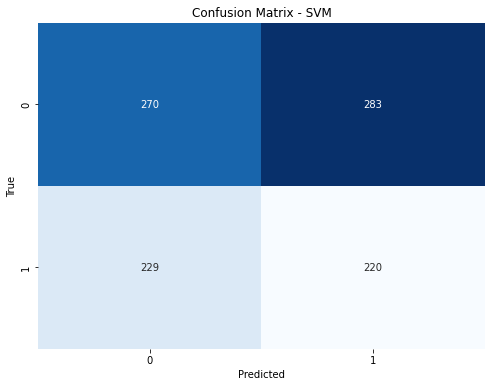

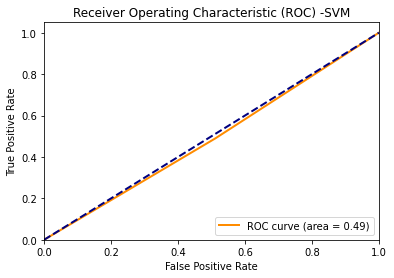

In [13]:
svm_accuracy, svm_precision, svm_recall, svm_fscore = SVM_classifier.svm_metrics(svm_predictions, y_test)
SVM_classifier.svm_confusion_matrix_plot(svm_predictions, y_test)
SVM_classifier.svm_roc_plot(svm_predictions, y_test)

## 2-Passive Aggressive

In [14]:
pa_predictions,pa_train_valid_predictions, pa_scores, pa_train_scores = PA_classifier.train_pa(X_train_t_v, y_train_t_v,
                                                     X_test_t_v,c = 0.01,iteration=500, tol=1e-7)

Execution time of PA: 0.14 seconds


PA - accuracy: 0.48902195608782434
PA - Precision: 0.44283121597096187
PA - Recall: 0.5434298440979956
PA - F-score: 0.488


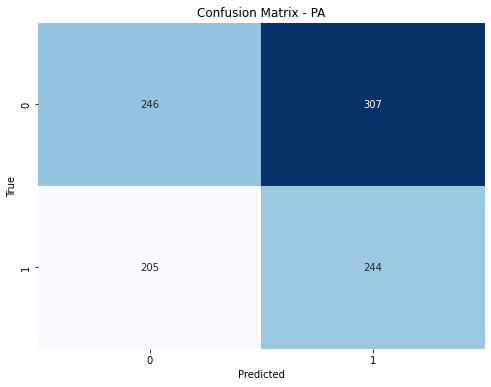

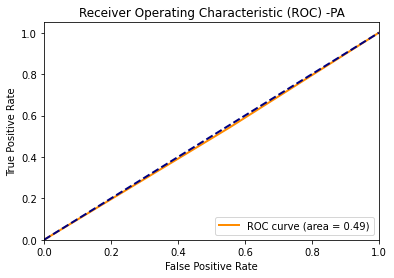

In [15]:
pa_accuracy, pa_precision, pa_recall, pa_fscore = PA_classifier.pa_metrics(pa_predictions, y_test)
PA_classifier.pa_confusion_matrix_plot(pa_predictions, y_test)
PA_classifier.pa_roc_plot(pa_predictions, y_test)

## 3-XGBoost

In [16]:
params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 20,  # maximum depth of a tree
    'subsample': 0.2,  # subsample ratio of the training instances
    'colsample_bytree': 0.8  # subsample ratio of columns when constructing each tree
}

xgb_predictions, xgb_train_valid_predictions, xgb_scores, xgb_train_scores = XGBoost_classifier.train_xgboost(X_train_t_v,y_train_valid,
                                                                                X_test_t_v,y_test,
                                                                               params)

Execution time of XGBoost: 7.74 seconds


XGBoost - accuracy: 0.5069860279441117
XGBoost - Precision: 0.46646795827123694
XGBoost - Recall: 0.6971046770601337
XGBoost - F-score: 0.5589285714285713


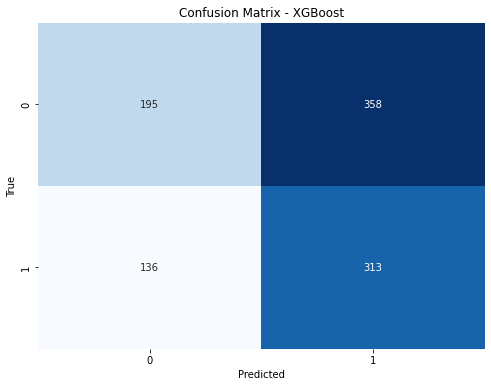

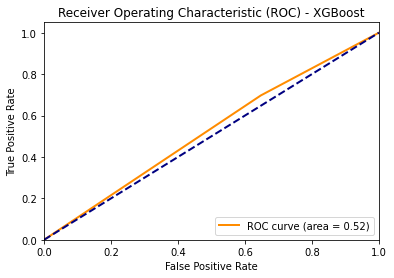

In [17]:
xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test)

## 4-LSTM

In [24]:
lstm_model, lstm_history = LSTM_classifier.train_lstm(vocab_size,
                                                      embedding_matrix,
                                                      X_train_t_v,
                                                      y_train_t_v,
                                                      epoches=10,
                                                      batch_size=128,
                                                      MAX_SEQUENCE_LENGTH=300,
                                                      EMBEDDING_DIM=150)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 300, 150)          1306050   
                                                                 
 lstm_layer1 (LSTM)          (None, 300, 128)          142848    
                                                                 
 lstm_layer2 (LSTM)          (None, 300, 64)           49408     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                      

In [25]:
lstm_train_valid_predictions, lstm_predictions, lstm_train_scores, lstm_scores = LSTM_classifier.predict_lstm(lstm_model,
                                                                              X_train_t_v,
                                                                              X_test_t_v,
                                                                             0.4)

287/287 [==============================] - 35s 122ms/step


LSTM - Accuracy: 0.6137724550898204
LSTM - Precision: 0.5545774647887324
LSTM - Recall: 0.7015590200445434
LSTM - F-score: 0.6194690265486725


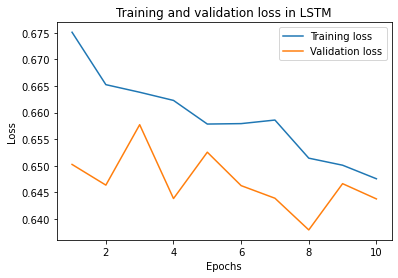

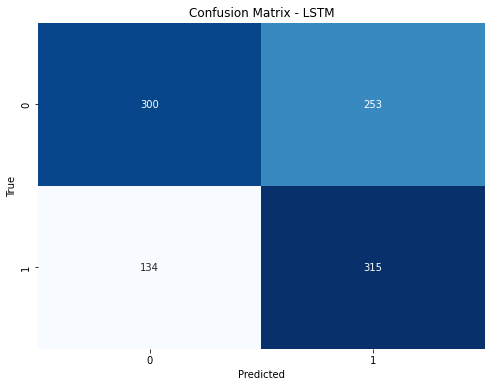

In [26]:
lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore = LSTM_classifier.lstm_metrics(lstm_predictions, y_test_t_v)
LSTM_classifier.lstm_loss_plot(lstm_history)
LSTM_classifier.lstm_confusion_matrix_plot(lstm_predictions, y_test_t_v)

## 5-BiLSTM

In [10]:
bilstm_model, bilstm_history = BiLSTM_classifier.train_bilstm(vocab_size,
                                                              X_train_t_v,
                                                              y_train_t_v, 8,64,
                                                              MAX_SEQUENCE_LENGTH = 300,
                                                              EMBEDDING_DIM = 150)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 150)          1306050   
                                                                 
 bidirectional (Bidirectiona  (None, 300, 256)         285696    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,760,259
Trainable params: 454,209
Non-

287/287 [==============================] - 70s 243ms/step
BiLSTM - Accuracy: 0.5868263473053892
BiLSTM - Precision: 0.5402298850574713
BiLSTM - Recall: 0.5233853006681515
BiLSTM - F-score: 0.5316742081447964


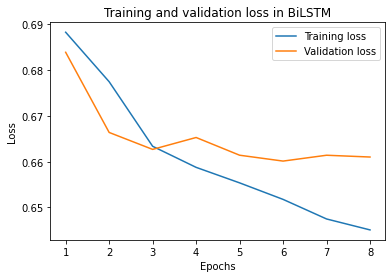

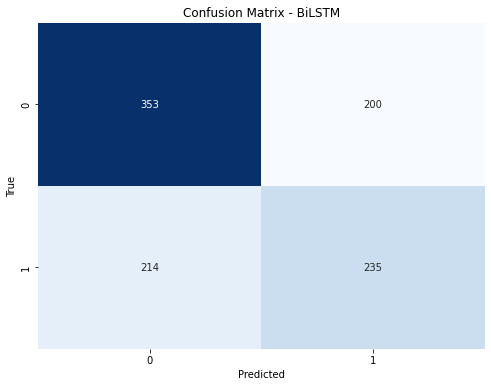

In [11]:
bilstm_train_predictions, bilstm_predictions, bilstm_train_scores,bilstm_scores = BiLSTM_classifier.predict_bilstm(bilstm_model,
                                                                                X_train_t_v, X_test_t_v, 0.4)
bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore=BiLSTM_classifier.bilstm_metrics(bilstm_predictions, y_test_t_v)
BiLSTM_classifier.bilstm_loss_plot(bilstm_history)
BiLSTM_classifier.bilstm_confusion_matrix_plot(bilstm_predictions, y_test_t_v)

## Evaluate Ensemblely!

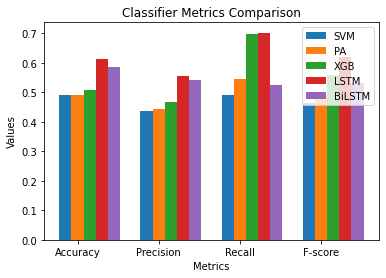

In [30]:
metrics = ['Accuracy','Precision','Recall','F-score'] 
svm = [svm_accuracy, svm_precision, svm_recall, svm_fscore] 
pa=[pa_accuracy, pa_precision, pa_recall, pa_fscore]
xgb=[xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore]
lstm = [lstm_accuracy, lstm_precision, lstm_recall, lstm_fscore] 
bilstm = [bilstm_accuracy, bilstm_precision, bilstm_recall, bilstm_fscore] 

bar_width = 0.15 
index = np.arange(len(metrics))
plt.bar(index, svm, bar_width, label='SVM')
plt.bar(index + bar_width, pa, bar_width, label='PA')
plt.bar(index + 2*bar_width, xgb, bar_width, label='XGB')
plt.bar(index + 3*bar_width, lstm, bar_width, label='LSTM')
plt.bar(index + 4*bar_width, bilstm, bar_width, label='BiLSTM')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Classifier Metrics Comparison')

plt.xticks(index + bar_width, metrics)
plt.legend()
plt.show()
        

In [21]:
import numpy as np
def ensemble_prediction():   
    votes = np.array([list(row) for row in zip(svm_predictions ,xgb_predictions, pa_predictions, lstm_predictions, bilstm_predictions)])
    column_sums = np.sum(votes, axis=1)
    averages_vote = []
    for column_sum in column_sums:
        average = column_sum / 5
        averages_vote.append(average.round())
    return averages_vote

In [28]:
y_pred_ensemble = ensemble_prediction()

accuracy = sum(y_pred_ensemble == y_test) / len(y_test)

precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred_ensemble, average='binary')
print("Model - accuracy:", accuracy)
print("Model - Precision:", precision)
print("Model - Recall:", recall)
print("Model - F-score:", fscore)

Model - accuracy: 0.5708582834331337
Model - Precision: 0.5168141592920354
Model - Recall: 0.6503340757238307
Model - F-score: 0.5759368836291914


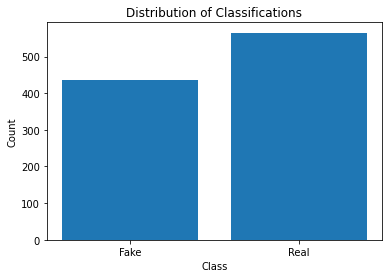

In [35]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']
plt.xticks(range(len(class_counts)), class_labels)
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## MLP Classifier

In [29]:
xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)

stacked_X_train = np.hstack((X_train_t_v, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             bilstm_train_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))
                           ))


In [26]:
mlp_predictions = MLP_classifier.build_mlp(stacked_X_train, y_train_valid,stacked_X_test)

Execution time of MLP: 16.07 seconds


In [27]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))
print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.57      0.62      0.59       553
           1       0.48      0.43      0.45       449

    accuracy                           0.53      1002
   macro avg       0.52      0.52      0.52      1002
weighted avg       0.53      0.53      0.53      1002

MLP F-score: 0.5329341317365269
MLP Accuracy: 0.5329341317365269


In [1]:
MLP_classifier.mlp_metrics(mlp_predictions, y_test)

NameError: name 'MLP_classifier' is not defined

In [31]:
mlp_predictions2 = MLP_classifier.build_mlp_with_embedding(stacked_X_train, y_train_valid,stacked_X_test,
                                            embedding_matrix, vocab_size,
                                            embed_dim=150,input_length=305)

Epoch 1/5
144/144 [==============================] - 20s 137ms/step - loss: 0.2977 - accuracy: 0.8876
Epoch 2/5
144/144 [==============================] - 19s 132ms/step - loss: 0.2535 - accuracy: 0.9071
Epoch 3/5
144/144 [==============================] - 19s 132ms/step - loss: 0.2399 - accuracy: 0.9141
Epoch 4/5
144/144 [==============================] - 19s 133ms/step - loss: 0.2331 - accuracy: 0.9156
Epoch 5/5
32/32 [==============================] - 0s 8ms/step


In [34]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
# mlp2=[1 if p >= 0.5 else 0 for p in mlp_predictions2]
mlp2 = (mlp_predictions2 > 0.9).astype(int).flatten()
f_score = f1_score(y_test, mlp2, average='micro')
accuracy = accuracy_score(y_test, mlp2)
print(classification_report(y_test, mlp2))
print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.57      0.87      0.69       553
           1       0.54      0.19      0.28       449

    accuracy                           0.56      1002
   macro avg       0.55      0.53      0.48      1002
weighted avg       0.55      0.56      0.50      1002

MLP F-score: 0.563872255489022
MLP Accuracy: 0.563872255489022


In [217]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
# mlp2=[1 if p >= 0.5 else 0 for p in mlp_predictions2]
mlp2 = (mlp_predictions2 > 0.5).astype(int).flatten()
f_score = f1_score(y_test, mlp2, average='micro')
accuracy = accuracy_score(y_test, mlp2)
print(classification_report(y_test, mlp2))
print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.69      0.54      0.60       553
           1       0.55      0.70      0.62       449

    accuracy                           0.61      1002
   macro avg       0.62      0.62      0.61      1002
weighted avg       0.63      0.61      0.61      1002

MLP F-score: 0.6107784431137725
MLP Accuracy: 0.6107784431137725


## XGBoost stacked

XGBoost - accuracy: 0.6007984031936128
XGBoost - Precision: 0.5376344086021505
XGBoost - Recall: 0.779510022271715
XGBoost - F-score: 0.6363636363636364


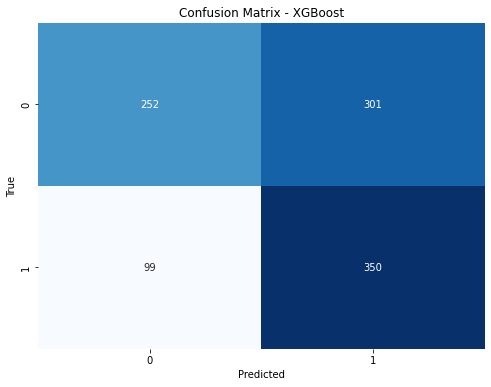

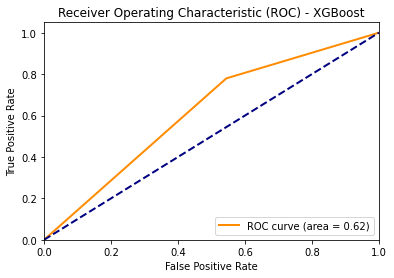

In [207]:
params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 5,  # maximum depth of a tree
    'subsample': 0.9,  # subsample ratio of the training instances
    'colsample_bytree': 0.9  # subsample ratio of columns when constructing each tree
}

xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)
stacked_X_train = np.hstack((X_train_t_v, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
#                              bilstm_train_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
#                             bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))
                           ))

xgb_predictions, xgb_train_valid_predictions,y1,y2 = train_xgboost(stacked_X_train,y_train_valid,
                                                                                stacked_X_test,y_test,params,
                                                                                rounds=50, threshold=0.4)

xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions, y_test)

XGBoost - accuracy: 0.6067864271457086
XGBoost - Precision: 0.5504587155963303
XGBoost - Recall: 0.6681514476614699
XGBoost - F-score: 0.6036217303822938


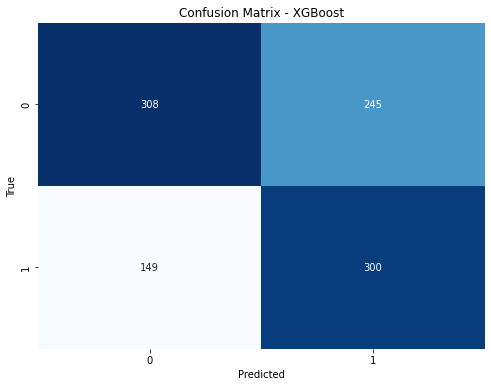

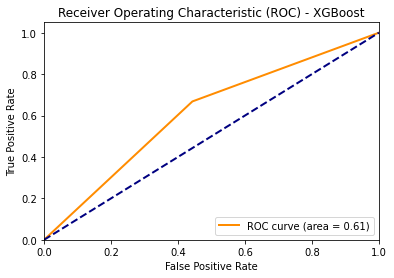

In [73]:
params = {
    'objective': 'binary:logistic',  # or 'multi:softmax' for multi-class classification
    'eval_metric': 'logloss',  # or other appropriate evaluation metric
    'eta': 0.01,  # learning rate
    'max_depth': 2,  # maximum depth of a tree
    'subsample': 0.5,  # subsample ratio of the training instances
    'colsample_bytree': 0.5  # subsample ratio of columns when constructing each tree
}
import xgboost as xgb

def train_xgboost(X_train, y_train, X_test, y_test, params, rounds=300, threshold=0.4):
    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    num_rounds = rounds  # number of boosting rounds (iterations)     
    model = xgb.train(params, dtrain, num_rounds)
    
    
    y_pred = model.predict(dtest)
    y_train_valid_pred = model.predict(dtrain)
    
    xgb_pred_binary = [1 if p >= threshold else 0 for p in y_pred]
    xgb_train_valid_pred_binary = [1 if p >= threshold else 0 for p in y_train_valid_pred]
    
    return xgb_pred_binary, xgb_train_valid_pred_binary, y_pred, y_train_valid_pred


xgb_train_valid_predictions = np.array(xgb_train_valid_predictions)
xgb_predictions= np.array(xgb_predictions)
stacked_X_train = np.hstack((X_train_t_v, 
                             svm_train_valid_predictions.reshape((-1, 1)),
                             xgb_train_valid_predictions.reshape((-1, 1)),
                             lstm_train_valid_predictions.reshape((-1, 1)),
                             bilstm_train_predictions.reshape((-1, 1)),
                             pa_train_valid_predictions.reshape((-1, 1))
                            ))
stacked_X_test = np.hstack((X_test_t_v, 
                            svm_predictions.reshape((-1, 1)),
                            xgb_predictions.reshape((-1, 1)),
                            lstm_predictions.reshape((-1, 1)),
                            bilstm_predictions.reshape((-1, 1)),
                            pa_predictions.reshape((-1, 1))
                           ))

xgb_predictions_stack, bla1,y1,y2 = train_xgboost(stacked_X_train,y_train_valid,
                                                                                stacked_X_test,y_test,params,
                                                                                rounds=20, threshold=0.4)

xgb_accuracy, xgb_precision, xgb_recall, xgb_fscore = XGBoost_classifier.xgb_metrics(xgb_predictions_stack, y_test)
XGBoost_classifier.xgb_confusion_matrix_plot(xgb_predictions_stack, y_test)
XGBoost_classifier.xgb_roc_plot(xgb_predictions_stack, y_test)